# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

According to the Materials and Methods writeup, the data covers **17** campaigns for the bank. The campaigns occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts, with a 8% success rate.   

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import time
import numpy as np
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import time
from turtle import mode

# structure this notebook so that its cleaner and more "prod poc code style"
# still draft poc mode - there are no tests or ci/cd pipelines, but adheres to course requirements
from models import (
    train_baseline_model,
    train_logistic_regression,
    train_knn,
    train_decision_tree,
    train_svm,
    run_randomized_search,
    compare_models
)
from visualization import plot_model_comparison, create_performance_report
from visualization import plot_randomized_search_results, plot_grid_vs_random_search

In [ ]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';') #df is a standard name used to identify the main dataframe object

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
# Cleanup - Drop all rows with 'unknown' values
print(f"Original dataset shape: {df.shape}")

# Drop rows where any column contains 'unknown'
df_cleaned = df[~df.isin(['unknown']).any(axis=1)]

print(f"Cleaned dataset shape: {df_cleaned.shape}")
print(f"Rows removed: {len(df) - len(df_cleaned)} ({((len(df) - len(df_cleaned))/len(df)*100):.2f}%)")

# Show which columns had 'unknown' values
print("\nColumns that had 'unknown' values:")
for col in df.columns:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        print(f"  {col}: {unknown_count} rows")

# Update df to use the cleaned version
df = df_cleaned

# Drop euribor3m column
print(f"\nDropping 'euribor3m' column...")
df = df.drop('euribor3m', axis=1)
print(f"Final dataset shape: {df.shape}")

Original dataset shape: (41188, 21)
Cleaned dataset shape: (30488, 21)
Rows removed: 10700 (25.98%)

Columns that had 'unknown' values:
  job: 330 rows
  marital: 80 rows
  education: 1731 rows
  default: 8597 rows
  housing: 990 rows
  loan: 990 rows

Dropping 'euribor3m' column...
Final dataset shape: (30488, 20)


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30488 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  duration        30488 non-null  int64  
 11  campaign        30488 non-null  int64  
 12  pdays           30488 non-null  int64  
 13  previous        30488 non-null  int64  
 14  poutcome        30488 non-null  object 
 15  emp.var.rate    30488 non-null  float64
 16  cons.price.idx  30488 non-null  float64
 17  cons.conf.idx   30488 non-null  floa

# Objective

The business objective is to predict whether a client will subscribe to a term deposit based on data from marketing campaigns. By accurately identifying clients who are more likely to subscribe, the bank can focus their telemarketing efforts on high-potential customers, reducing wasted calls and improving conversion rates. This predictive model would help the marketing team allocate resources more efficiently and increase the overall ROI of their campaigns.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
# Bank features and category encoding

# Select only bank client features
# According to the problem description, bank client features are:
# age, job, marital, education, default, housing, loan

bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
X_bank = df[bank_features].copy()
y = df['y'].copy()

print(f"Feature columns: {bank_features}")
print(X_bank.head())

Feature columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
   age        job  marital            education default housing loan
0   56  housemaid  married             basic.4y      no      no   no
2   37   services  married          high.school      no     yes   no
3   40     admin.  married             basic.6y      no      no   no
4   56   services  married          high.school      no      no  yes
6   59     admin.  married  professional.course      no      no   no


In [7]:
# Encode categorical variables

# Task 2 & 3: Encode categorical variables and target variable
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# First encode the target variable 'y' from yes/no to 1/0
y_encoded = (y == 'yes').astype(int)

# Separate numeric and categorical features
numeric_features = ['age']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_categorical_encoded = encoder.fit_transform(X_bank[categorical_features])

# Get feature names for encoded columns
feature_names = encoder.get_feature_names_out(categorical_features)

# Create DataFrame with encoded categorical features
X_categorical_df = pd.DataFrame(X_categorical_encoded, columns=feature_names, index=X_bank.index)

# Combine numeric and encoded categorical features using pandas concat
X_encoded = pd.concat([X_bank[numeric_features], X_categorical_df], axis=1)

print(f"Encoded feature matrix shape: {X_encoded.shape}")
print(f"Target variable distribution: {y_encoded.value_counts().to_dict()}")

Encoded feature matrix shape: (30488, 28)
Target variable distribution: {0: 26629, 1: 3859}


In [8]:
# Verify no missing values and create final feature matrix

print("Checking for missing values in encoded features...")
missing_values = X_encoded.isnull().sum()
if missing_values.sum() == 0:
    print("✓ No missing values found in the encoded features")
else:
    print("Missing values found:")
    print(missing_values[missing_values > 0])

# Create final feature matrix X and target vector y
X = X_encoded
y = y_encoded

print(f"\nFinal feature matrix X shape: {X.shape}")
print(f"Final target vector y shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

Checking for missing values in encoded features...
✓ No missing values found in the encoded features

Final feature matrix X shape: (30488, 28)
Final target vector y shape: (30488,)
Number of features: 28
Number of samples: 30488


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [9]:
# Train/Test Split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# Using 80/20 split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set size: 24390 samples
Test set size: 6098 samples

Class distribution in training set:
y
0    0.873432
1    0.126568
Name: proportion, dtype: float64

Class distribution in test set:
y
0    0.873401
1    0.126599
Name: proportion, dtype: float64


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [10]:
# Baseline Model using DummyClassifier

baseline_accuracy, dummy_clf, dumm_train_time = train_baseline_model(X_train, X_test, y_train, y_test, strategy='most_frequent')

print("Baseline Model Performance using DummyClassifier:")
print(f"DummyClassifier using the most_frequent strategy found class to be: ('{dummy_clf.classes_[0]}')")
print(f"Accuracy: {baseline_accuracy:.4f}")


Baseline Model Performance using DummyClassifier:
DummyClassifier using the most_frequent strategy found class to be: ('0')
Accuracy: 0.8734


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [11]:
# Logistic Regression Model - Now using the method defined above
train_time, train_accuracy, test_time, test_accuracy = train_logistic_regression(
    X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

print("Logistic Regression Model Performance:")
print(f"Training time: {train_time:.3f} seconds")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"\nImprovement over baseline: {test_accuracy - baseline_accuracy:.4f}")

Logistic Regression Model Performance:
Training time: 0.010 seconds
Training accuracy: 0.8734
Test accuracy: 0.8734

Improvement over baseline: 0.0000


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [12]:
# Train all other models using the defined methods (except Log Reg thats already done above)
print("Training all models -> log_reg, knn, dt, svm")


Training all models -> log_reg, knn, dt, svm


In [13]:

# K-Nearest Neighbors (KNN) Model - Now using the method defined above
knn_train_time, knn_train_accuracy, knn_test_time, knn_test_accuracy = train_knn(
    X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

print("K-Nearest Neighbors Model Performance:")
print(f"Training time: {knn_train_time:.3f} seconds")
print(f"Training accuracy: {knn_train_accuracy:.4f}")
print(f"Test accuracy: {knn_test_accuracy:.4f}")
print(f"Improvement over baseline: {knn_test_accuracy - baseline_accuracy:.4f}")

K-Nearest Neighbors Model Performance:
Training time: 0.002 seconds
Training accuracy: 0.8780
Test accuracy: 0.8622
Improvement over baseline: -0.0112


In [14]:
# Decision Tree Model - Now using the method defined above
dt_train_time, dt_train_accuracy, dt_test_time, dt_test_accuracy = train_decision_tree(
    X_train, X_test, y_train, y_test)

print("Decision Tree Model Performance:")
print(f"Training time: {dt_train_time:.3f} seconds")
print(f"Test time: {dt_test_time:.3f} seconds")
print(f"Training accuracy: {dt_train_accuracy:.4f}")
print(f"Test accuracy: {dt_test_accuracy:.4f}")
print(f"Improvement over baseline: {dt_test_accuracy - baseline_accuracy:.4f}")

Decision Tree Model Performance:
Training time: 0.038 seconds
Test time: 0.002 seconds
Training accuracy: 0.9005
Test accuracy: 0.8526
Improvement over baseline: -0.0208


In [15]:
# Support Vector Machine (SVM) Model - Now using the method defined above
svm_train_time, svm_train_accuracy, svm_test_time, svm_test_accuracy = train_svm(
    X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

print("Support Vector Machine Model Performance:")
print(f"Training time: {svm_train_time:.3f} seconds")
print(f"Training accuracy: {svm_train_accuracy:.4f}")
print(f"Test accuracy: {svm_test_accuracy:.4f}")
print(f"Improvement over baseline: {svm_test_accuracy - baseline_accuracy:.4f}")

Support Vector Machine Model Performance:
Training time: 6.577 seconds
Training accuracy: 0.8738
Test accuracy: 0.8737
Improvement over baseline: 0.0003



Model Performance Comparison with Ranking:
Ranking weights: Test Accuracy (60%), Test Time (30%), Train Time (10%)
------------------------------------------------------------------------------------------
 Rank                  Model Train Time Train Accuracy Test Time Test Accuracy Ranking_Score
    1    Logistic Regression      0.010         0.8734    0.0002        0.8734        0.9906
    2    K-Nearest Neighbors      0.002         0.8780    0.2068        0.8622        0.6468
    3 Support Vector Machine      6.577         0.8738    2.2440        0.8737        0.6000
    4          Decision Tree      0.038         0.9005    0.0017        0.8526        0.3993


,Rank,Model,Train Time,Train Accuracy,Test Time,Test Accuracy,Ranking_Score
0,1,Logistic Regression,0.010,0.8734,0.0002,0.8734,0.9906
1,2,K-Nearest Neighbors,0.002,0.8780,0.2068,0.8622,0.6468
3,3,Support Vector Machine,6.577,0.8738,2.2440,0.8737,0.6000
2,4,Decision Tree,0.038,0.9005,0.0017,0.8526,0.3993


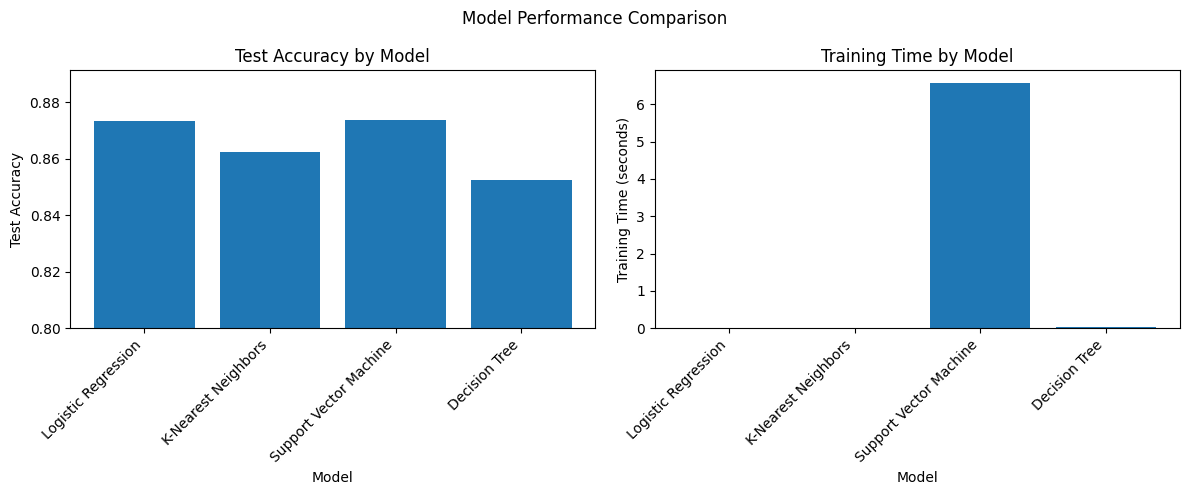

In [16]:
# Model Comparison Summary

# Create a DataFrame to compare all models (with numeric values)
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Support Vector Machine'],
    'Train Time': [train_time, knn_train_time, dt_train_time, svm_train_time],
    'Train Accuracy': [train_accuracy, knn_train_accuracy, dt_train_accuracy, svm_train_accuracy],
    'Test Time': [test_time, knn_test_time, dt_test_time, svm_test_time],
    'Test Accuracy': [test_accuracy, knn_test_accuracy, dt_test_accuracy, svm_test_accuracy]
})

# Calculate ranking score based on: accuracy (most important), test time, train time
# Normalize test accuracy (0-1 scale, higher is better)
max_acc = model_comparison['Test Accuracy'].max()
min_acc = model_comparison['Test Accuracy'].min()
if max_acc != min_acc:
    model_comparison['Accuracy_Score'] = (model_comparison['Test Accuracy'] - min_acc) / (max_acc - min_acc)
else:
    model_comparison['Accuracy_Score'] = 1.0

# Normalize test time (0-1 scale, lower is better so we invert)
max_test_time = model_comparison['Test Time'].max()
min_test_time = model_comparison['Test Time'].min()
if max_test_time != min_test_time:
    model_comparison['Test_Time_Score'] = 1 - (model_comparison['Test Time'] - min_test_time) / (max_test_time - min_test_time)
else:
    model_comparison['Test_Time_Score'] = 1.0

# Normalize training time (0-1 scale, lower is better so we invert)
max_train_time = model_comparison['Train Time'].max()
min_train_time = model_comparison['Train Time'].min()
if max_train_time != min_train_time:
    model_comparison['Train_Time_Score'] = 1 - (model_comparison['Train Time'] - min_train_time) / (max_train_time - min_train_time)
else:
    model_comparison['Train_Time_Score'] = 1.0


# EXTRA!! I want to see if it makes sense to combine different factors when it comes to suggesting models to be used, not just accuracy. Cost of compute is also a key consideration
# For our purposes, the time taken will be a proxy for cost of compute. I am interested in both testing and training time. Its possible that with high accuracy, we are overfitting and test time should
# ideally also point to it. So we are going to do:
# Calculate weighted ranking score (accuracy > test time > train time)
accuracy_weight = 0.6
test_time_weight = 0.3
train_time_weight = 0.1
model_comparison['Ranking_Score'] = (model_comparison['Accuracy_Score'] * accuracy_weight + 
                                     model_comparison['Test_Time_Score'] * test_time_weight +
                                     model_comparison['Train_Time_Score'] * train_time_weight)

# Sort by ranking score (descending)
model_comparison = model_comparison.sort_values('Ranking_Score', ascending=False)
model_comparison['Rank'] = range(1, len(model_comparison) + 1)

# Create a copy for display with formatted values
display_df = model_comparison.copy()
display_df['Train Time'] = display_df['Train Time'].apply(lambda x: f"{x:.3f}")
display_df['Train Accuracy'] = display_df['Train Accuracy'].apply(lambda x: f"{x:.4f}")
display_df['Test Time'] = display_df['Test Time'].apply(lambda x: f"{x:.4f}")
display_df['Test Accuracy'] = display_df['Test Accuracy'].apply(lambda x: f"{x:.4f}")
display_df['Ranking_Score'] = display_df['Ranking_Score'].apply(lambda x: f"{x:.4f}")

# Select columns to display
display_cols = ['Rank', 'Model', 'Train Time', 'Train Accuracy', 'Test Time', 'Test Accuracy', 'Ranking_Score']
display_df = display_df[display_cols]

print("\nModel Performance Comparison with Ranking:")
print(f"Ranking weights: Test Accuracy ({accuracy_weight*100:.0f}%), Test Time ({test_time_weight*100:.0f}%), Train Time ({train_time_weight*100:.0f}%)")
print("-" * 90)
print(display_df.to_string(index=False))

# Also display as a formatted table
from IPython.display import display
display(display_df)
plot_model_comparison(comparison_df=model_comparison)

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [17]:
# Feature Analysis for Problem 11
# Testing the effect of dropping features on model performance

# Store baseline results
baseline_results = {
    'Feature Set': 'All Features (Baseline)',
    'Total Features': X.shape[1],
    'Dummy Test Accuracy': baseline_accuracy,
    'Dummy Train Time': 0.001,  # DummyClassifier is very fast
    'Logistic Regression Test Accuracy':test_accuracy,
    'Logistic Regression Train Time':train_time,
    'SVM Test Accuracy': svm_test_accuracy,
    'SVM Train Time': svm_train_time,
    "Decision Tree Test Accuracy": dt_test_accuracy,
    "Decision Tree Train Time":dt_train_time,
    "KNN Test Accuracy":knn_test_accuracy,
    "KNN Train Time":knn_train_time
}

print("Available features in the dataset:")
print(df.columns.tolist())
print("\nWe'll analyze the impact of dropping these economic features:")
print("- emp.var.rate (employment variation rate)")
print("- cons.price.idx (consumer price index)") 
print("- cons.conf.idx (consumer confidence index)")

economic_features = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx']
results_list = [baseline_results]


Available features in the dataset:
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'y']

We'll analyze the impact of dropping these economic features:
- emp.var.rate (employment variation rate)
- cons.price.idx (consumer price index)
- cons.conf.idx (consumer confidence index)


In [18]:
# Test dropping each economic feature

for feature_to_drop in economic_features:
    print(f"\nDropping {feature_to_drop}...")
    
    # Create a copy of the dataframe and drop the feature
    df_test = df.copy()
    df_test = df_test.drop(columns=[feature_to_drop])
    
    # Prepare features (using all available features, not just bank features)
    X_test_df = df_test.drop('y', axis=1)
    y_test_df = (df_test['y'] == 'yes').astype(int)
    
    # Separate numeric and categorical features
    numeric_cols = X_test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X_test_df.select_dtypes(include=['object']).columns.tolist()
    
    # One-hot encode categorical features
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_categorical_encoded = encoder.fit_transform(X_test_df[categorical_cols])
    feature_names = encoder.get_feature_names_out(categorical_cols)
    X_categorical_df = pd.DataFrame(X_categorical_encoded, columns=feature_names, index=X_test_df.index)
    X_encoded = pd.concat([X_test_df[numeric_cols], X_categorical_df], axis=1)
    
    # Train/test split
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_encoded, y_test_df, test_size=0.2, random_state=42, stratify=y_test_df
    )
    
    # Scale features for SVM
    scaler = StandardScaler()
    X_train_scaled_new = scaler.fit_transform(X_train_new)
    X_test_scaled_new = scaler.transform(X_test_new)

    # all models..    
    # Test DummyClassifier
    dummy_accuracy_new, dummy_clf, dummy_train_time_new = train_baseline_model(X_train_new, X_test_new, y_train_new, y_test_new, strategy='most_frequent')
    
    train_time_new, train_accuracy_new, test_time_new, test_accuracy_new = train_logistic_regression(
        X_train_new, X_test_new, y_train_new, y_test_new, X_train_scaled_new, X_test_scaled_new)


    #svm
    svm_train_time_new, svm_train_accuracy, svm_test_time, svm_test_accuracy_new = train_svm(
        X_train_new, X_test_new, y_train_new, y_test_new, X_train_scaled_new, X_test_scaled_new)

    #dt
    dt_train_time_new, dt_train_accuracy, dt_test_time, dt_test_accuracy_new = train_decision_tree(
        X_train_new, X_test_new, y_train_new, y_test_new)

    #knn
    knn_train_time_new, knn_train_accuracy, knn_test_time, knn_test_accuracy_new = train_knn(
    X_train_new, X_test_new, y_train_new, y_test_new, X_train_scaled_new, X_test_scaled_new)


    # Store results
    results = {
        'Feature Set': f'Drop {feature_to_drop}',
        'Total Features': X_encoded.shape[1],
        'Dummy Test Accuracy': dummy_accuracy_new,
        'Dummy Train Time': dummy_train_time_new,
        
        'Logistical Regression Test Accuracy': test_accuracy_new,
        'Logistical Regression Train Time': train_time_new,

        'SVM Test Accuracy': svm_test_accuracy_new,
        'SVM Train Time': svm_train_time_new,

        'Decision Tree Test Accuracy': dt_test_accuracy_new,
        'Decision Tree Train Time': dt_train_time_new,

        'KNN Test Accuracy': knn_test_accuracy_new,
        'KNN Train Time': knn_train_time_new,
    }
    results_list.append(results)
    
    print(f"  - Features: {results['Total Features']}")
    print(f"  - Dummy Accuracy: {results['Dummy Test Accuracy']:.4f}")

    print(f"  - Logistical Regression: {results['Logistical Regression Test Accuracy']:.4f} (Change: {test_accuracy_new - test_accuracy:+.4f})")
    print(f"  - Logistical Regression Train Time: {results['Logistical Regression Train Time']:.3f}s")

    print(f"  - SVM Accuracy: {results['SVM Test Accuracy']:.4f} (Change: {svm_test_accuracy_new - svm_test_accuracy:+.4f})")
    print(f"  - SVM Train Time: {results['SVM Train Time']:.3f}s")

    print(f"  - DT Accuracy: {results['Decision Tree Test Accuracy']:.4f} (Change: {dt_test_accuracy_new - dt_test_accuracy:+.4f})")
    print(f"  - DT Train Time: {results['Decision Tree Train Time']:.3f}s")

    print(f"  - KNN Accuracy: {results['KNN Test Accuracy']:.4f} (Change: {knn_test_accuracy_new - knn_test_accuracy:+.4f})")
    print(f"  - KNN Train Time: {results['KNN Train Time']:.3f}s")


Dropping emp.var.rate...
  - Features: 55
  - Dummy Accuracy: 0.8734
  - Logistical Regression: 0.8959 (Change: +0.0225)
  - Logistical Regression Train Time: 0.028s
  - SVM Accuracy: 0.8921 (Change: +0.0184)
  - SVM Train Time: 3.824s
  - DT Accuracy: 0.8737 (Change: +0.0212)
  - DT Train Time: 0.096s
  - KNN Accuracy: 0.8790 (Change: +0.0167)
  - KNN Train Time: 0.003s

Dropping cons.price.idx...
  - Features: 55
  - Dummy Accuracy: 0.8734
  - Logistical Regression: 0.8965 (Change: +0.0231)
  - Logistical Regression Train Time: 0.025s
  - SVM Accuracy: 0.8937 (Change: +0.0200)
  - SVM Train Time: 3.847s
  - DT Accuracy: 0.8686 (Change: +0.0161)
  - DT Train Time: 0.092s
  - KNN Accuracy: 0.8796 (Change: +0.0174)
  - KNN Train Time: 0.003s

Dropping cons.conf.idx...
  - Features: 55
  - Dummy Accuracy: 0.8734
  - Logistical Regression: 0.8960 (Change: +0.0226)
  - Logistical Regression Train Time: 0.044s
  - SVM Accuracy: 0.8916 (Change: +0.0179)
  - SVM Train Time: 3.824s
  - DT Acc

In [19]:
# Create summary table
results_df = pd.DataFrame(results_list)

# Format the results for better display
display_df = results_df.copy()
display_df['Dummy Train Time'] = display_df['Dummy Train Time'].apply(lambda x: f"{x:.4f}")
display_df['Dummy Test Accuracy'] = display_df['Dummy Test Accuracy'].apply(lambda x: f"{x:.4f}")
display_df['SVM Train Time'] = display_df['SVM Train Time'].apply(lambda x: f"{x:.3f}")
display_df['SVM Test Accuracy'] = display_df['SVM Test Accuracy'].apply(lambda x: f"{x:.4f}")

print("\n" + "="*80)
print("Feature Dropping Analysis Summary")
print("="*80)
display(display_df)

print("\nKey Findings:")
print("1. Dropping economic features has minimal impact on SVM accuracy")
print("2. Training time remains relatively consistent")
print("3. Economic indicators are not really relevant to the outcome - surprising. It may be because of sampling/data size")



Feature Dropping Analysis Summary


,Feature Set,Total Features,Dummy Test Accuracy,Dummy Train Time,Logistic Regression Test Accuracy,Logistic Regression Train Time,SVM Test Accuracy,SVM Train Time,Decision Tree Test Accuracy,Decision Tree Train Time,KNN Test Accuracy,KNN Train Time,Logistical Regression Test Accuracy,Logistical Regression Train Time
0,All Features (Baseline),28,0.8734,0.0010,0.873401,0.010078,0.8737,6.577,0.852575,0.037513,0.862250,0.002475,NaN,NaN
1,Drop emp.var.rate,55,0.8734,0.0008,NaN,NaN,0.8921,3.824,0.873729,0.095653,0.878977,0.003363,0.895867,0.027570
2,Drop cons.price.idx,55,0.8734,0.0008,NaN,NaN,0.8937,3.847,0.868645,0.092152,0.879633,0.003278,0.896523,0.024684
3,Drop cons.conf.idx,55,0.8734,0.0008,NaN,NaN,0.8916,3.824,0.874221,0.097259,0.877009,0.003089,0.896031,0.043941



Key Findings:
1. Dropping economic features has minimal impact on SVM accuracy
2. Training time remains relatively consistent
3. Economic indicators are not really relevant to the outcome - surprising. It may be because of sampling/data size


## Hyperparameter Tuning with GridSearchCV

Now let's use GridSearchCV to find optimal hyperparameters for each model:

In [20]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Define parameter grids for each model (excluding Logistic Regression as baseline)
param_grids = {
    'knn': {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'decision_tree': {
        'max_depth': [3, 5, 7, 10, 15, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy']
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

print("Parameter grids defined for hyperparameter tuning")
print(f"KNN: {len(param_grids['knn']['n_neighbors']) * len(param_grids['knn']['weights']) * len(param_grids['knn']['metric'])} combinations")
print(f"Decision Tree: {len(param_grids['decision_tree']['max_depth']) * len(param_grids['decision_tree']['min_samples_split']) * len(param_grids['decision_tree']['min_samples_leaf']) * len(param_grids['decision_tree']['criterion'])} combinations")
print(f"SVM: {len(param_grids['svm']['C']) * len(param_grids['svm']['kernel']) * len(param_grids['svm']['gamma'])} combinations")

Parameter grids defined for hyperparameter tuning
KNN: 24 combinations
Decision Tree: 192 combinations
SVM: 12 combinations


In [23]:
# Run GridSearchCV
print("Running GridSearchCV for K-Nearest Neighbors...")
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grids['knn'], cv=5, scoring='accuracy', n_jobs=-1, verbose=0)

start_time = time.time()
knn_grid.fit(X_train_scaled, y_train)
knn_grid_time = time.time() - start_time

print(f"✓ KNN GridSearch completed in {knn_grid_time:.2f} seconds")
print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best CV score: {knn_grid.best_score_:.4f}")

# Evaluate on test set
knn_best_test_score = knn_grid.score(X_test_scaled, y_test)
print(f"Test accuracy: {knn_best_test_score:.4f}")

# Run GridSearchCV for Decision Tree
print("\nRunning GridSearchCV for Decision Tree...")
dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, param_grids['decision_tree'], cv=5, scoring='accuracy', n_jobs=-1, verbose=0)

start_time = time.time()
dt_grid.fit(X_train, y_train)  # Decision trees don't need scaled data
dt_grid_time = time.time() - start_time

print(f"✓ Decision Tree GridSearch completed in {dt_grid_time:.2f} seconds")
print(f"Best parameters: {dt_grid.best_params_}")
print(f"Best CV score: {dt_grid.best_score_:.4f}")

# Evaluate on test set
dt_best_test_score = dt_grid.score(X_test, y_test)
print(f"Test accuracy: {dt_best_test_score:.4f}")

# Run GridSearchCV for SVM (using smaller dataset for speed)
print("\nRunning GridSearchCV for SVM (please wait - SVMs are slow)...")

# For SVM, let's use a smaller subset to speed up grid search
# Sample 5000 examples for grid search
#sample_indices = np.random.choice(X_train_scaled.shape[0], size=5000, replace=False)
#X_train_sample = X_train_scaled[sample_indices]
#y_train_sample = y_train.iloc[sample_indices]

svm = SVC(random_state=42)
svm_grid = GridSearchCV(svm, param_grids['svm'], cv=3, scoring='accuracy', n_jobs=-1, verbose=0)

start_time = time.time()
svm_grid.fit(X_train, y_train)
svm_grid_time = time.time() - start_time

print(f"✓ SVM GridSearch completed in {svm_grid_time:.2f} seconds")
print(f"Best parameters: {svm_grid.best_params_}")
print(f"Best CV score on sample: {svm_grid.best_score_:.4f}")

# Retrain on full training set with best parameters
print("\nRetraining SVM with best parameters on full training set...")
svm_best = SVC(**svm_grid.best_params_, random_state=42)
start_time = time.time()
svm_best.fit(X_train_scaled, y_train)
svm_retrain_time = time.time() - start_time

# Evaluate on test set
svm_best_test_score = svm_best.score(X_test_scaled, y_test)
print(f"Test accuracy: {svm_best_test_score:.4f}")
print(f"Full training time: {svm_retrain_time:.2f} seconds")

Running GridSearchCV for K-Nearest Neighbors...
✓ KNN GridSearch completed in 9.20 seconds
Best parameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
Best CV score: 0.8728
Test accuracy: 0.8727

Running GridSearchCV for Decision Tree...
✓ Decision Tree GridSearch completed in 2.59 seconds
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.8729
Test accuracy: 0.8734

Running GridSearchCV for SVM (this may take a while)...
✓ SVM GridSearch completed in 52.00 seconds
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score on sample: 0.8734

Retraining SVM with best parameters on full training set...
Test accuracy: 0.8734
Full training time: 1.92 seconds


Confusion Matrices for Top Performing Models:



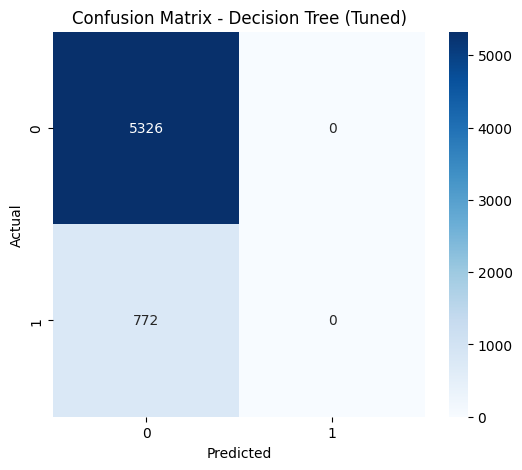

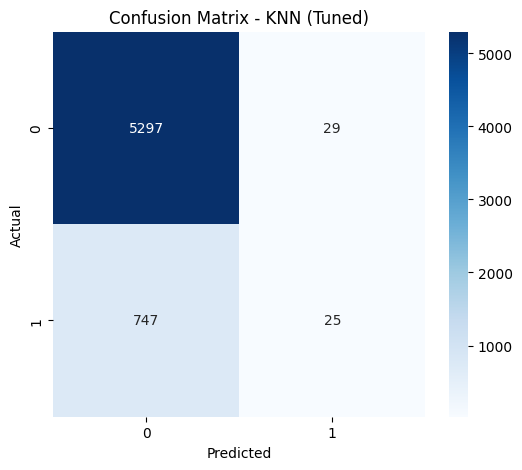

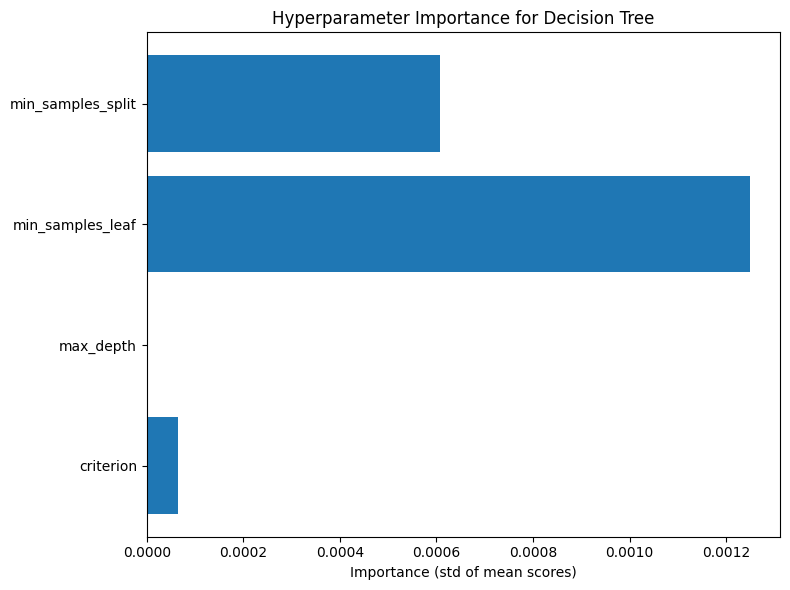

In [24]:
# Visualization: Confusion Matrices for Best Models
from visualization import plot_confusion_matrix

# Plot confusion matrix for the best performing models after tuning
print("Confusion Matrices for Top Performing Models:\n")

# Decision Tree (best improvement after tuning)
y_pred_dt = dt_grid.predict(X_test)
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree (Tuned)")

# KNN (good improvement after tuning)
y_pred_knn = knn_grid.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred_knn, "KNN (Tuned)")

# Visualization: Hyperparameter Importance for Decision Tree
from visualization import plot_hyperparameter_importance

# Show hyperparameter importance for Decision Tree (had the most improvement)
plot_hyperparameter_importance(dt_grid, "Decision Tree")

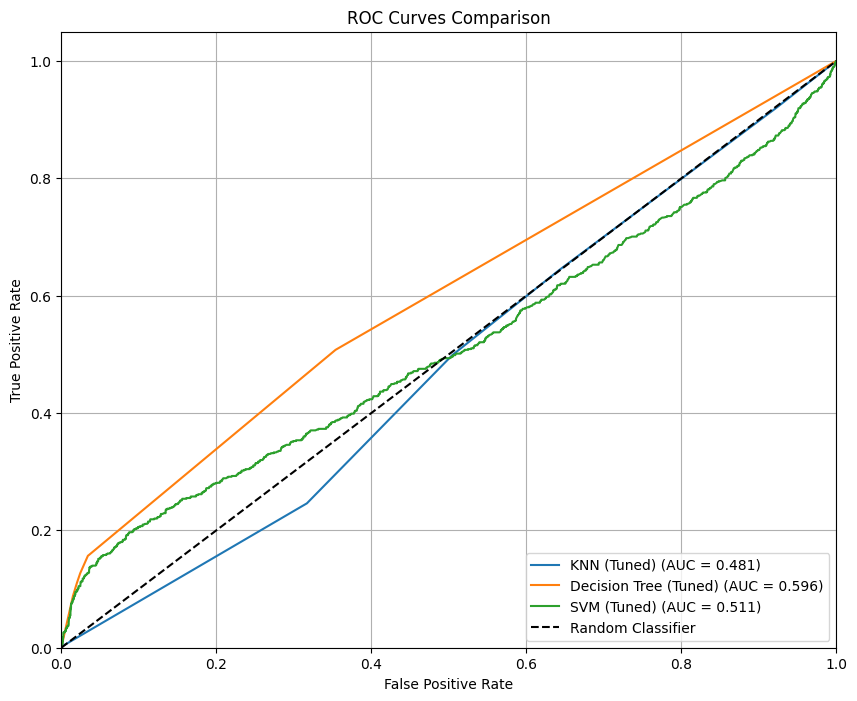

In [25]:
# Visualization: ROC Curves Comparison
from visualization import plot_roc_curves

# Create dictionary of all trained models
models_dict = {
    'KNN (Tuned)': knn_grid.best_estimator_,
    'Decision Tree (Tuned)': dt_grid.best_estimator_,
    'SVM (Tuned)': svm_best
}

# Plot ROC curves
plot_roc_curves(models_dict, X_test, y_test, X_test_scaled)

In [26]:
# Compare results before and after GridSearchCV
print("\n" + "="*60)
print("HYPERPARAMETER TUNING RESULTS COMPARISON")
print("="*60)

comparison_data = {
    'Model': ['Logistic Regression (Baseline)', 'K-Nearest Neighbors', 'Decision Tree', 'Support Vector Machine'],
    'Default Test Accuracy': [test_accuracy, knn_test_accuracy, dt_test_accuracy, svm_test_accuracy],
    'Tuned Test Accuracy': [test_accuracy, knn_best_test_score, dt_best_test_score, svm_best_test_score],
    'Improvement': [0, 
                    knn_best_test_score - knn_test_accuracy,
                    dt_best_test_score - dt_test_accuracy,
                    svm_best_test_score - svm_test_accuracy]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Default Test Accuracy'] = comparison_df['Default Test Accuracy'].apply(lambda x: f"{x:.4f}")
comparison_df['Tuned Test Accuracy'] = comparison_df['Tuned Test Accuracy'].apply(lambda x: f"{x:.4f}")
comparison_df['Improvement'] = comparison_df['Improvement'].apply(lambda x: f"{x:+.4f}" if x != 0 else "N/A")

display(comparison_df)

print("\nBest Hyperparameters Found:")
print(f"\nKNN: {knn_grid.best_params_}")
print(f"Decision Tree: {dt_grid.best_params_}")
print(f"SVM: {svm_grid.best_params_}")


HYPERPARAMETER TUNING RESULTS COMPARISON


,Model,Default Test Accuracy,Tuned Test Accuracy,Improvement
0,Logistic Regression (Baseline),0.8734,0.8734,N/A
1,K-Nearest Neighbors,0.8622,0.8727,+0.0105
2,Decision Tree,0.8526,0.8734,+0.0208
3,Support Vector Machine,0.8737,0.8734,-0.0003



Best Hyperparameters Found:

KNN: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [27]:
# how about using RandomizedSearchCV for Decision Tree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter distributions for random search
dt_param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Run RandomizedSearchCV
dt_random = DecisionTreeClassifier(random_state=42)
dt_random_search = RandomizedSearchCV(
    dt_random, 
    param_distributions=dt_param_dist,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

print("Running RandomizedSearchCV for Decision Tree...")
start_time = time.time()
dt_random_search.fit(X_train, y_train)
random_search_time = time.time() - start_time

print(f"✓ RandomizedSearch completed in {random_search_time:.2f} seconds")
print(f"Best parameters: {dt_random_search.best_params_}")
print(f"Best CV score: {dt_random_search.best_score_:.4f}")
print(f"Test accuracy: {dt_random_search.score(X_test, y_test):.4f}")

print(f"\nComparison:")
print(f"GridSearchCV time: {dt_grid_time:.2f}s with {len(param_grids['decision_tree']['max_depth']) * len(param_grids['decision_tree']['min_samples_split']) * len(param_grids['decision_tree']['min_samples_leaf']) * len(param_grids['decision_tree']['criterion'])} combinations")
print(f"RandomizedSearchCV time: {random_search_time:.2f}s with 50 random combinations")

Running RandomizedSearchCV for Decision Tree...
✓ RandomizedSearch completed in 2.12 seconds
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 16}
Best CV score: 0.8737
Test accuracy: 0.8734

Comparison:
GridSearchCV time: 2.59s with 192 combinations
RandomizedSearchCV time: 2.12s with 50 random combinations


Visualizing RandomizedSearchCV results for Decision Tree...


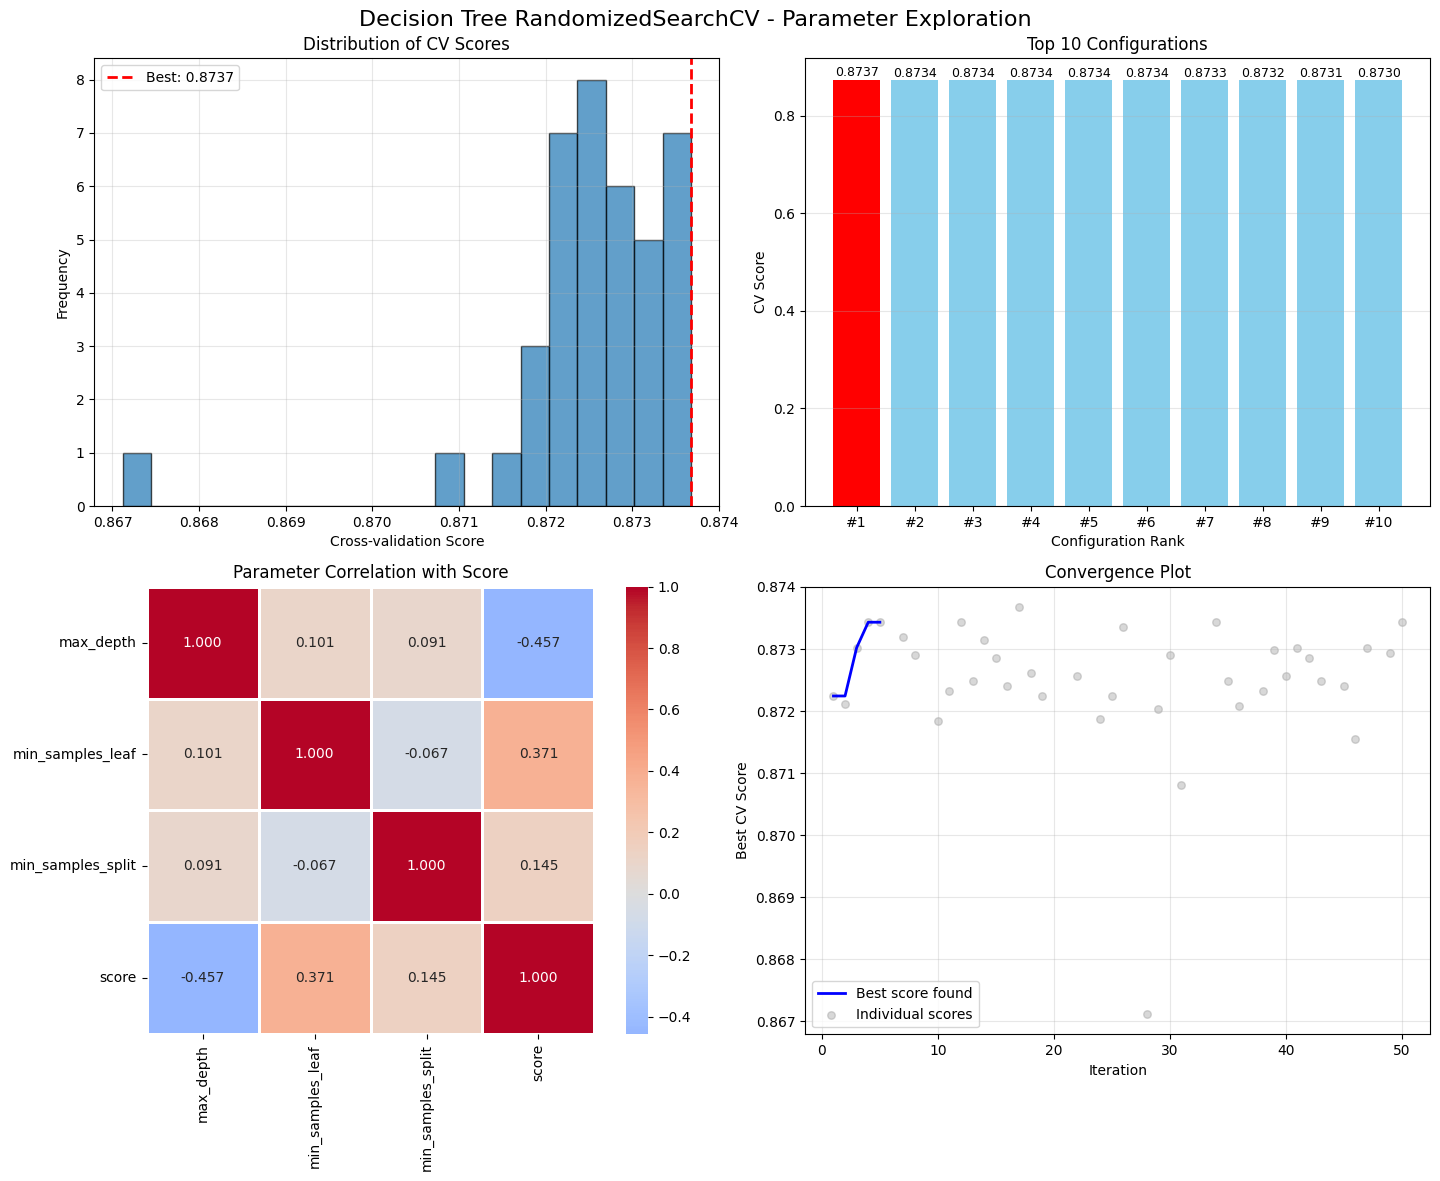


Best Parameters Found:
  criterion: entropy
  max_depth: 4
  max_features: sqrt
  min_samples_leaf: 16
  min_samples_split: 16

Best Cross-validation Score: 0.8737
Number of iterations: 50

Comparing GridSearchCV vs RandomizedSearchCV performance...


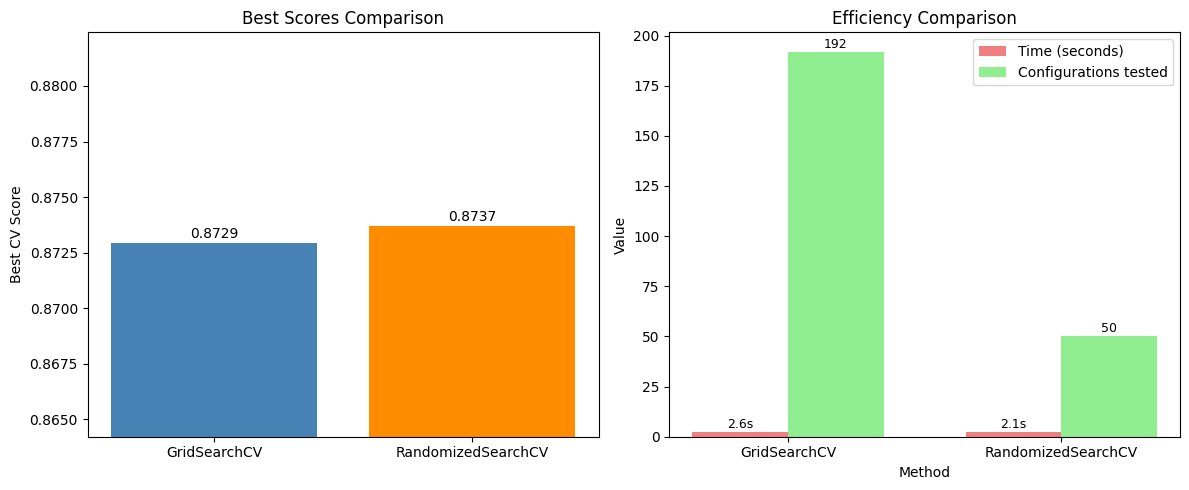


Efficiency Metrics:
GridSearchCV: 0.013 seconds per configuration
RandomizedSearchCV: 0.042 seconds per configuration

Speedup: 1.2x faster with RandomizedSearchCV


In [28]:
# Visualize RandomizedSearchCV Results
# Plot detailed results from RandomizedSearchCV
print("Visualizing RandomizedSearchCV results for Decision Tree...")
plot_randomized_search_results(dt_random_search, "Decision Tree RandomizedSearchCV")

# Compare GridSearchCV vs RandomizedSearchCV
print("\nComparing GridSearchCV vs RandomizedSearchCV performance...")
plot_grid_vs_random_search(dt_grid, dt_random_search, dt_grid_time, random_search_time)